C:\Users\suchi\AppData\Local\Temp\ipykernel_23292\1221553121.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2018-01-01', end=today)
[*********************100%***********************]  1 of 1 completed
C:\Users\suchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0644
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0050
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0035
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0036
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0027
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0032
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0026
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0030
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0025
Epoch 10/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0022
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


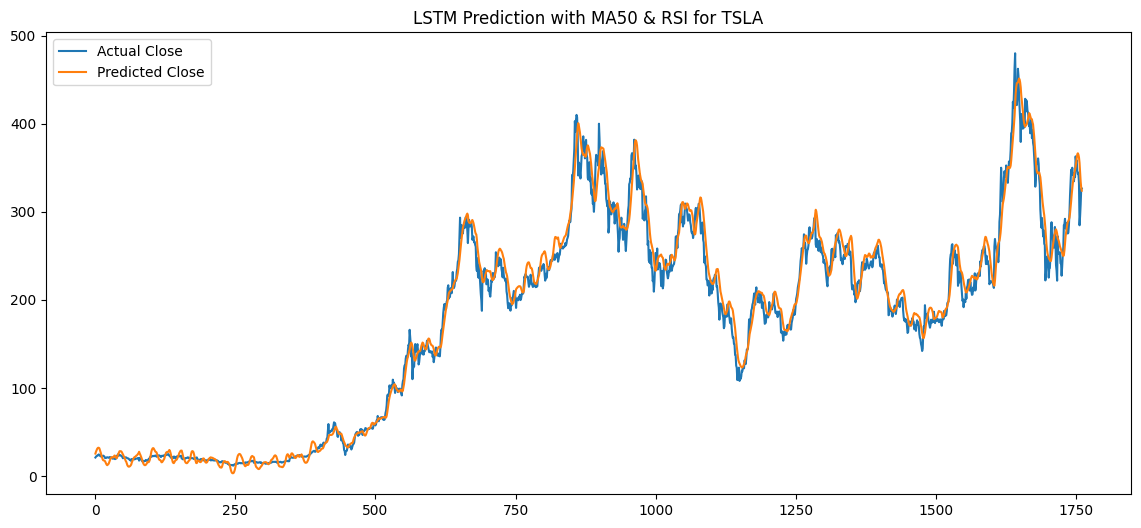

In [1]:
# stock_lstm.ipynb (Jupyter Notebook)

# 1. Imports
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import os

# 2. Fetch Data
today = datetime.date.today()
ticker = 'TSLA'  # Change to any company, e.g., 'INFY.NS', 'GOOGL'
df = yf.download(ticker, start='2018-01-01', end=today)

# 3. Technical Indicators
df['MA50'] = df['Close'].rolling(50).mean()
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = -delta.where(delta < 0, 0).rolling(14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# 4. Drop missing rows
df = df[['Close', 'MA50', 'RSI']].dropna()

# 5. Normalize
data = df.copy()
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

# 6. Create Sequences
look_back = 60
X, y = [], []
for i in range(look_back, len(scaled)):
    X.append(scaled[i-look_back:i])
    y.append(scaled[i, 0])
X, y = np.array(X), np.array(y)

# 7. Build Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# 8. Train Model
model.fit(X, y, epochs=10, batch_size=32)

# 9. Predict & Plot
predicted = model.predict(X)
predicted_close = scaler.inverse_transform(
    np.concatenate([predicted, np.zeros((predicted.shape[0], 2))], axis=1)
)[:, 0]

actual_close = scaler.inverse_transform(
    np.concatenate([y.reshape(-1, 1), np.zeros((y.shape[0], 2))], axis=1)
)[:, 0]

plt.figure(figsize=(14, 6))
plt.plot(actual_close, label='Actual Close')
plt.plot(predicted_close, label='Predicted Close')
plt.title(f'LSTM Prediction with MA50 & RSI for {ticker}')
plt.legend()
plt.show()

# 10. Save Model
os.makedirs("model", exist_ok=True)
model.save("model/lstm_model.h5")